In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py # Add the current directory to the path.  
from utils import loading, scoring
from gerkin import dream,params
import numpy as np
import matplotlib.pyplot as plt
import pandas

## Subject Clustering

In [2]:
# Load the observed perceptual descriptor data for the high concentration of each pair.  
Y,_ = dream.make_Y_obs(['training','leaderboard','testset'],target_dilution='high',imputer='mask')

# Turn into a 3-D array.  
y = np.ma.dstack([Y['subject'][i] for i in range(1,50)])
# Compute mean and std across molecules. 
ybar = np.vstack((y.mean(axis=0),y.std(axis=0))).T.data  

The Y['mean_std'] matrix now has shape (476x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (476x21) molecules by perceptual descriptors, one for each subject


In [3]:
# Cluster the data.  
from scipy.cluster.hierarchy import fclusterdata,dendrogram,linkage
fclusterdata(ybar,1)
Z = linkage(ybar, 'ward')

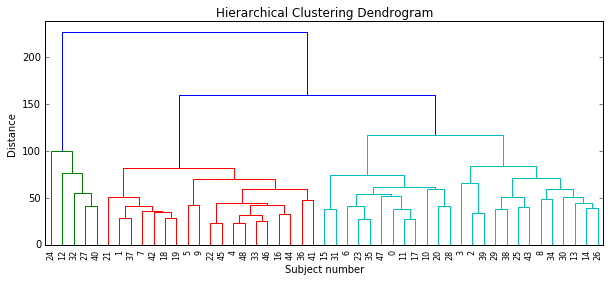

In [4]:
# Create the dendrogram
plt.figure(figsize=(10, 4))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Subject number')
plt.ylabel('Distance')
d = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    distance_sort = 'ascending'
)

# Create a copy of the data that is sorted by subjection position in the dendrogram.
y_dend = ybar.copy()
for i in range(49):
    y_dend[i,:] = ybar[int(d['ivl'][i]),:]

In [5]:
# Swap the red and cyan branch for visualization since the ordering is arbitrary
divl_ = np.array(d['ivl'])
divl_[5:30] = d['ivl'][24:]
divl_[30:] = d['ivl'][5:24]
y_dend_ = y_dend.copy()
for i in range(49):
    y_dend_[i,:] = ybar[int(divl_[i]),:]
y_dend = y_dend_

In [6]:
# Create a version of the same that is normalized to the mean value for each descriptor.  
y_dend_norm = y_dend / np.mean(y_dend,axis=0,keepdims=True)

## Fig. 2C and some auxiliary plots

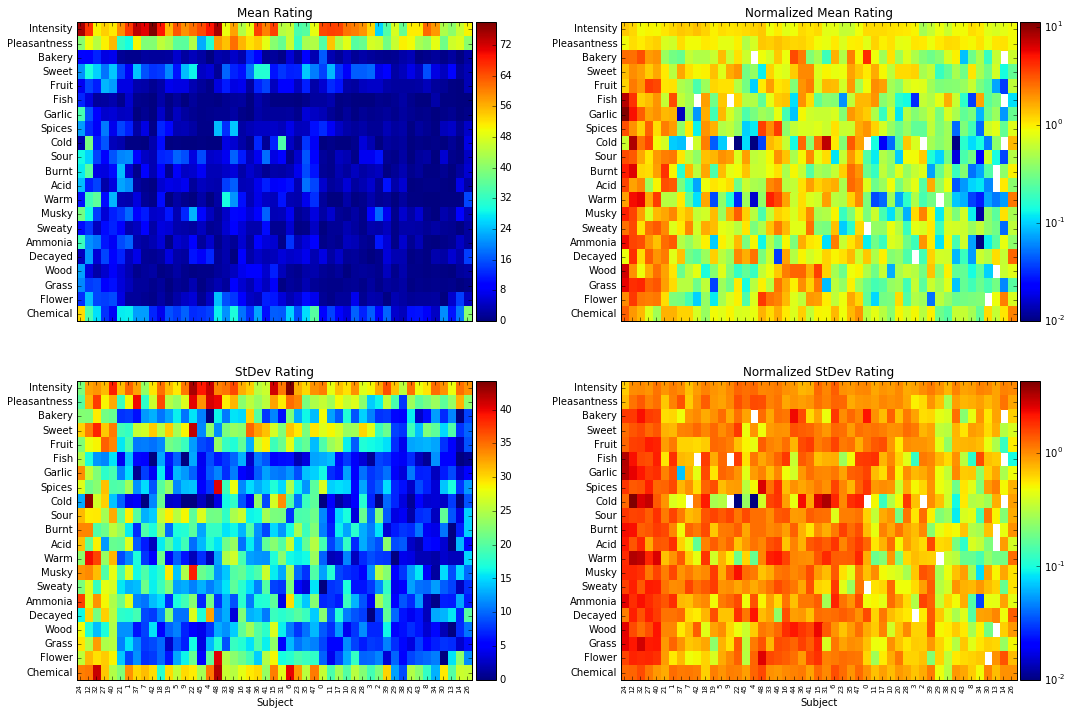

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
descriptors = loading.get_descriptors(format=True)
fig,axes = plt.subplots(2,2,figsize=(15,10),sharex=True,sharey=False)
im = {}
im[0] = axes[0,0].pcolor(y_dend[:,:21].T)
axes[0,0].set_title('Mean Rating')
y_ = y_dend_norm[:,:21]
im[1] = axes[0,1].pcolor(y_.T,norm=LogNorm(vmin=y_.min()+0.01, vmax=y_.max()))
axes[0,1].set_title('Normalized Mean Rating')
im[2] = axes[1,0].pcolor(y_dend[:,21:].T)
axes[1,0].set_title('StDev Rating')
y_ = y_dend_norm[:,21:]
im[3] = axes[1,1].pcolor(y_.T,norm=LogNorm(vmin=y_.min()+0.01, vmax=y_.max()))
axes[1,1].set_title('Normalized StDev Rating')

for i,ax in enumerate(axes.flat):
    if i>=2:
        ax.set_xlabel('Subject')
    ax.set_xticks(np.arange(49)+0.35)
    ax.set_yticks(np.arange(21)+0.5)
    ax.set_yticklabels(descriptors)
    ax.set_xticklabels(d['ivl'],rotation=90,size=7)
    ax.set_xlim(0,49)
    ax.set_ylim(21,0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "5%", pad = 0.05)
    plt.colorbar(im[i], cax=cax)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2,wspace=0.3)

### Mean vs StDev for each descriptor; each point is one subject (Colors are as in dendrogram)

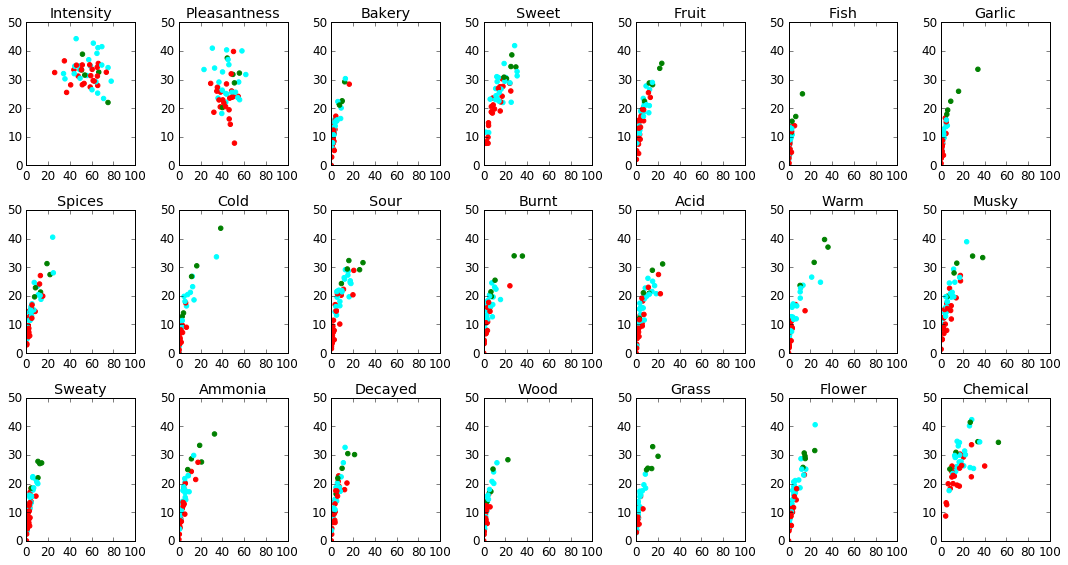

In [8]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
fig,axes = plt.subplots(3,7,figsize=(15,8))
colors = ['k']*49
for i in range(0,5):
    subject = int(d['ivl'][i])
    colors[subject] = 'green'
for i in range(5,27):
    subject = int(d['ivl'][i])
    colors[subject] = 'red'
for i in range(27,49):
    subject = int(d['ivl'][i])
    colors[subject] = 'cyan'
for i,ax in enumerate(axes.flat):
    ax.scatter(ybar[:,i],ybar[:,21+i],color=colors)
    ax.set_xlim(0,100)
    ax.set_ylim(0,50)
    ax.set_title(descriptors[i].split('/')[0])
plt.tight_layout()

In [40]:
# Load predictions from previously run models
from scipy.io import matlab
yg = matlab.loadmat('../../data/sc2_yg.mat') # Load Yuanfang's predictions.  
yg = yg['a2']
resort = [sorted([str(i) for i in range(1,50)]).index(str(s)) for s in range(1,50)]
yg = yg[:,resort]
y = np.ma.dstack([Y['subject'][i] for i in range(1,50)])

rg = np.load('../../data/rg.npy') # Load Rick's predictions.  

# Take the mean of these two sets of predictions
pred = rg*0.5 + yg*0.5

### Prediction quality vs StDev for each descriptor; each point is one subject (Colors are as in dendrogram)

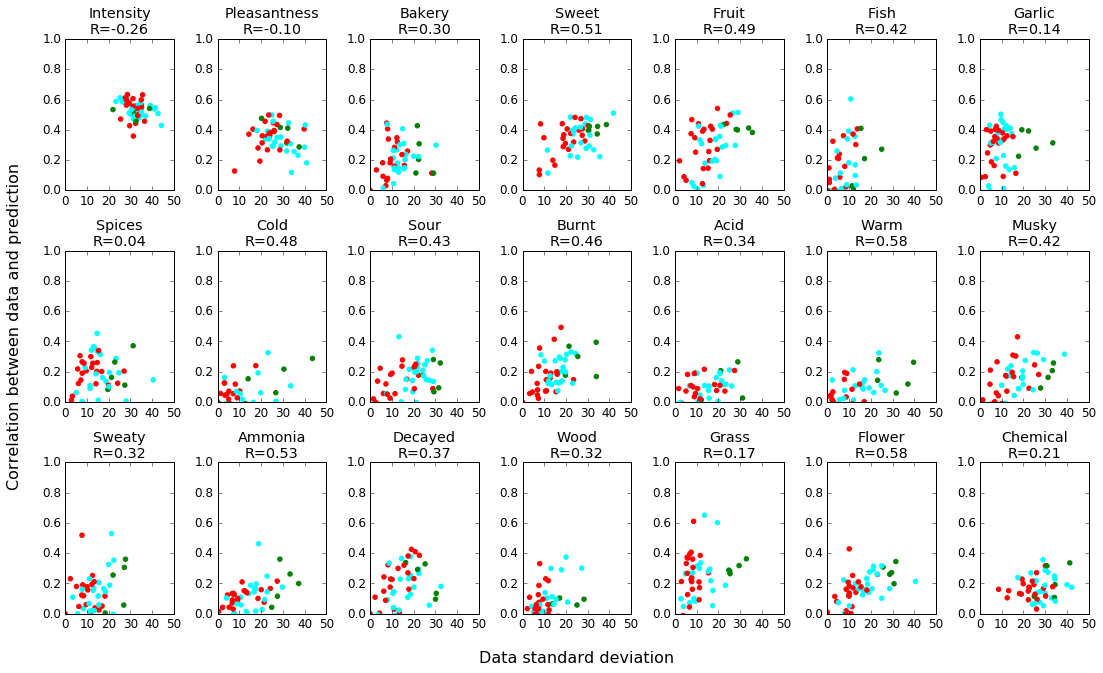

In [41]:
mpl.rcParams.update({'font.size': 12})
rs = np.zeros(21)
fig,axes = plt.subplots(3,7,figsize=(15,9))        
for i,ax in enumerate(axes.flat):
    ax.scatter(y[:,i,:].std(axis=0),pred[i,:],color=colors)
    ax.set_xlim(0,50)
    ax.set_ylim(0,1)
    ax.set_xticks([0,10,20,30,40,50])
    rs[i] = np.ma.corrcoef(y[:,i,:].std(axis=0),pred[i,:])[1,0]
    ax.set_title('%s\nR=%.2f' % (descriptors[i].split('/')[0],rs[i]))
plt.tight_layout()
axes.flat[7].set_ylabel('Correlation between data and prediction',size=16,labelpad=20)
axes.flat[17].set_xlabel('Data standard deviation',size=16,labelpad=20);

In [11]:
rs_shuffle = np.zeros((21,1000))
for j in range(1000):
    randos = np.argsort(np.random.random(21))
    for i in range(21):
        rs_shuffle[i,j] = np.ma.corrcoef(y[:,i,:].std(axis=0),pred[randos[i],:])[1,0]

In [12]:
sorted(rs_shuffle.ravel())[int(0.975*21000)]

0.4543697037348528

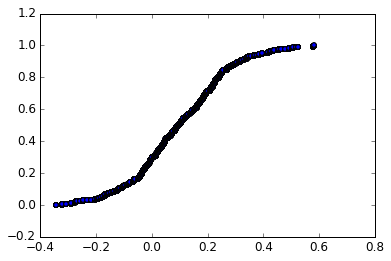

In [13]:
plt.scatter(sorted(rs_shuffle.ravel()),np.linspace(0,1,21000))

In [14]:
rs_shuffle = np.zeros((21,1000))
for j in range(1000):
    randos = np.argsort(np.random.random(49))
    for i in range(21):
        rs_shuffle[i,j] = np.ma.corrcoef(y[:,i,:].std(axis=0),pred[i,randos])[1,0]

In [15]:
sorted(rs_shuffle.ravel())[int(0.975*21000)]

0.27957305641741959

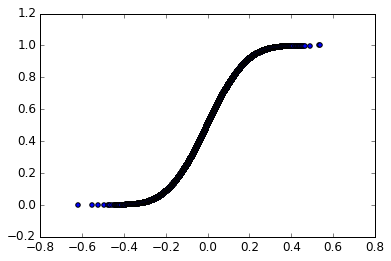

In [16]:
plt.scatter(sorted(rs_shuffle.ravel()),np.linspace(0,1,21000))

## Fig. 2D

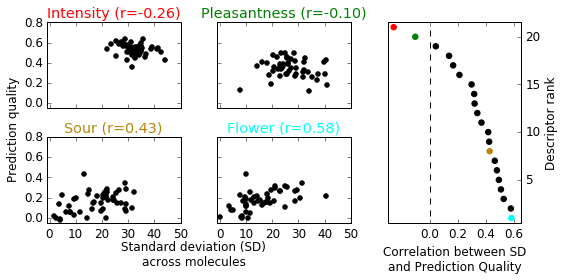

In [53]:
plt.figure(figsize=(8,4))

# Colors for the dots
# Indices are determined by the sort order of the correlations
colors2 = ['k']*21
colors2[20] = 'red'; colors2[7] = 'darkgoldenrod'; colors2[19] = 'green'; colors2[0] = 'cyan'

# The sorted correlation values
ax1 = plt.subplot2grid((2,3), (0, 2), rowspan=2)
ax1.scatter(sorted(rs,reverse=True),np.arange(1,22),marker='o',s=30,color=colors2)
ax1.set_xlim(-0.3,0.65)
ax1.set_ylim(0.5,21.5)
ax1.set_xticks([0,0.2,0.4,0.6])
ax1.plot([0,0],[0,21],'--',color='k')
ax1.set_xlabel('Correlation between SD\nand Prediction Quality')
ax1.set_ylabel('Descriptor rank')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

# Prepare the subplots for specific descriptors
ax2 = plt.subplot2grid((2,3), (0, 0))
ax3 = plt.subplot2grid((2,3), (0, 1))
ax4 = plt.subplot2grid((2,3), (1, 0))
ax5 = plt.subplot2grid((2,3), (1, 1))

# Plot the data for specific descriptors
for ax,i,color in [(ax2,0,'red'),(ax3,1,'green'),(ax4,9,'darkgoldenrod'),(ax5,19,'cyan')]:
    ax.scatter(y[:,i,:].std(axis=0),pred[i,:],color='k')
    ax.set_title('%s (r=%.2f)' % (descriptors[i],rs[i]),color=color)
    ax.set_xlim(-1,50)
    ax.set_ylim(-0.05,0.75)
    ax.set_yticks([0,0.2,0.4,0.6,0.8])
    if ax in [ax2,ax3]:
        ax.set_xticklabels([])
    if ax in [ax3,ax5]:
        ax.set_yticklabels([])

# Finish the plot
ax4.set_xlabel('Standard deviation (SD)\nacross molecules')
ax4.set_ylabel('Prediction quality')
plt.tight_layout()
ax4.xaxis.set_label_coords(1.1, -0.2)
ax4.yaxis.set_label_coords(-0.2, 1.1)
plt.savefig('../../figures/subject_stdev.eps',format='eps')

In [43]:
[descriptors[np.argsort(rs)[i]] for i in range(21)]

['Intensity',
 'Pleasantness',
 'Spices',
 'Garlic',
 'Grass',
 'Chemical',
 'Bakery',
 'Wood',
 'Sweaty',
 'Acid',
 'Decayed',
 'Musky',
 'Fish',
 'Sour',
 'Burnt',
 'Cold',
 'Fruit',
 'Sweet',
 'Ammonia',
 'Warm',
 'Flower']

In [46]:
descriptors

['Intensity',
 'Pleasantness',
 'Bakery',
 'Sweet',
 'Fruit',
 'Fish',
 'Garlic',
 'Spices',
 'Cold',
 'Sour',
 'Burnt',
 'Acid',
 'Warm',
 'Musky',
 'Sweaty',
 'Ammonia',
 'Decayed',
 'Wood',
 'Grass',
 'Flower',
 'Chemical']